In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier,plot_tree,plot_importance
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import eli5
from sklearn.feature_extraction import DictVectorizer
import pandas_profiling as pp
from pandas_profiling import ProfileReport

**Function to read data from CSV file**

In [2]:
def import_csv_data(filepath):
    
    df = pd.read_csv(filepath, 
                          index_col=[0], 
                          parse_dates=['EFFECTIVEDATE','PAIDTODATE','INCEPTIONDATE'], 
                          infer_datetime_format=True)
    
    return df

In [3]:
data = import_csv_data('../data/persistency/training_and_test_data.csv')

data.head()

,PRODUCT,OCCUPATION,GENDER,EFFECTIVEDATE,UNDERWRITINGYEAR,TERM,ANB,FREQOFPAYMENT,PAYMETHOD,SUMASSURED,PAIDTODATE,PREMIUM,OSPREM,INCEPTIONDATE,STATUS
POLICYNO,,,,,,,,,,,,,,,
8868646,BIMA YA KARO,TEACHER [CLASS 1],M,2015-01-09,2015,15,43,M,K,214592.00,2020-03-31,3000.0,2169.0,1/9/2015,ACTIVE
8868518,BIMA YA KARO,SALES REPRESENTATIVE [CLASS 3],M,2015-01-04,2015,10,42,M,K,139388.00,2015-07-31,3300.0,188100.0,12/11/2014,FINAL LAPSED
MMM/06645/2016,MADISON MONEY MAX,DEAN OF STUDENTS [CLASS 1],M,2016-01-01,2016,8,68,M,S,816721.66,2016-01-31,21000.0,1071000.0,1/1/2016,ACTIVE
MMM/06258/2015,MADISON MONEY MAX,DOCTOR [CLASS 1],M,2015-01-12,2015,8,67,M,S,1000000.00,2015-12-01,35886.0,1901958.0,1/12/2015,ACTIVE
MMM/00119/2015,MADISON MONEY MAX,DEAN OF STUDENTS [CLASS 1],M,2015-01-01,2015,8,67,M,S,500000.00,2016-01-31,82747.0,4213329.0,1/1/2015,ACTIVE


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36641 entries, 8868646 to BYK/01782/2015
Data columns (total 15 columns):
PRODUCT             36641 non-null object
OCCUPATION          36641 non-null object
GENDER              36641 non-null object
EFFECTIVEDATE       36641 non-null datetime64[ns]
UNDERWRITINGYEAR    36641 non-null int64
TERM                36641 non-null int64
ANB                 36641 non-null int64
FREQOFPAYMENT       36641 non-null object
PAYMETHOD           36628 non-null object
SUMASSURED          36641 non-null float64
PAIDTODATE          36599 non-null datetime64[ns]
PREMIUM             36641 non-null float64
OSPREM              36641 non-null float64
INCEPTIONDATE       36641 non-null object
STATUS              36641 non-null object
dtypes: datetime64[ns](2), float64(3), int64(3), object(7)
memory usage: 4.5+ MB


**Horizontal chart to show policy status distribution**

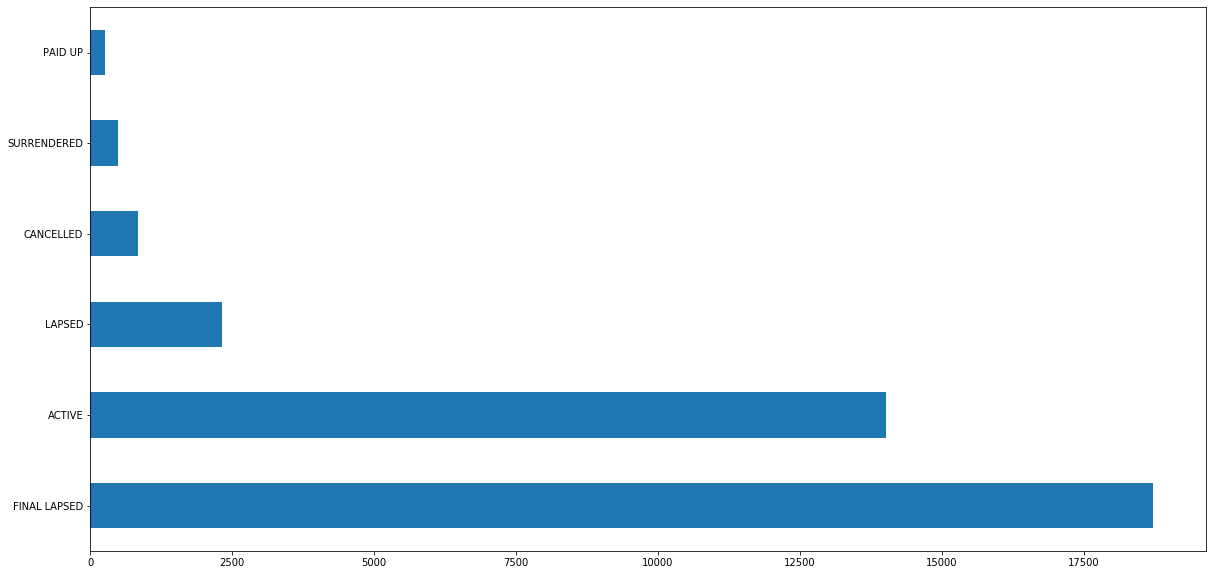

In [5]:
policy = data['STATUS'].value_counts().head(30).plot(kind='barh', figsize=(20,10))

In [6]:
data['STATUS'].value_counts()

FINAL LAPSED    18719
ACTIVE          14010
LAPSED           2321
CANCELLED         838
SURRENDERED       497
PAID UP           256
Name: STATUS, dtype: int64

**Function to Clean up Policy Status**

In [7]:
def status_Cleanup(policies):  
    frequency = policies['FREQOFPAYMENT']
    premium = policies['PREMIUM'] 
    outstandingBal = policies['OSPREM']
    polStatus = policies['STATUS']
        
    if polStatus == 'SURRENDERED':
        return polStatus
    elif polStatus == 'CANCELLED':
        return polStatus
    elif polStatus == 'PAID UP':
        return polStatus
    elif polStatus == 'FINAL LAPSED':
        return polStatus
    elif polStatus == 'LAPSED':
        return polStatus
    elif polStatus == 'ACTIVE':
        noOfOutstandingInstalment = outstandingBal/premium
        if frequency == 'M':
            if noOfOutstandingInstalment > 3 and noOfOutstandingInstalment <= 12:
                return 'LAPSED'
            elif noOfOutstandingInstalment > 12:
                return 'FINAL LAPSED'
            else:
                return polStatus
        elif frequency == 'Q':
            if noOfOutstandingInstalment > 2 and noOfOutstandingInstalment <= 4:
                return 'LAPSED'
            elif noOfOutstandingInstalment > 4:
                return 'FINAL LAPSED'
            else:
                return polStatus
        elif frequency == 'F':
            if noOfOutstandingInstalment > 1:
                return 'FINAL LAPSED'
            else:
                return polStatus
        elif frequency == 'S':
            if noOfOutstandingInstalment > 1 and noOfOutstandingInstalment <= 2:
                return 'LAPSED'
            elif noOfOutstandingInstalment > 2:
                return 'FINAL LAPSED'
            else:
                return polStatus
        elif frequency == 'A':
            if noOfOutstandingInstalment > 1 and noOfOutstandingInstalment <= 2:
                return 'LAPSED'
            elif noOfOutstandingInstalment > 2:
                return 'FINAL LAPSED'
            else:
                return polStatus
        elif frequency == 'W':
            if noOfOutstandingInstalment > 3 and noOfOutstandingInstalment <= 12:
                return 'LAPSED'
            elif noOfOutstandingInstalment > 12:
                return 'FINAL LAPSED'
            else:
                return polStatus
        else:
            return polStatus
      
    else:
        return polStatus         
            

**Clean up errorneous policy status**

In [8]:
data['STATUS'] = data.apply(lambda x: status_Cleanup(x), axis=1)

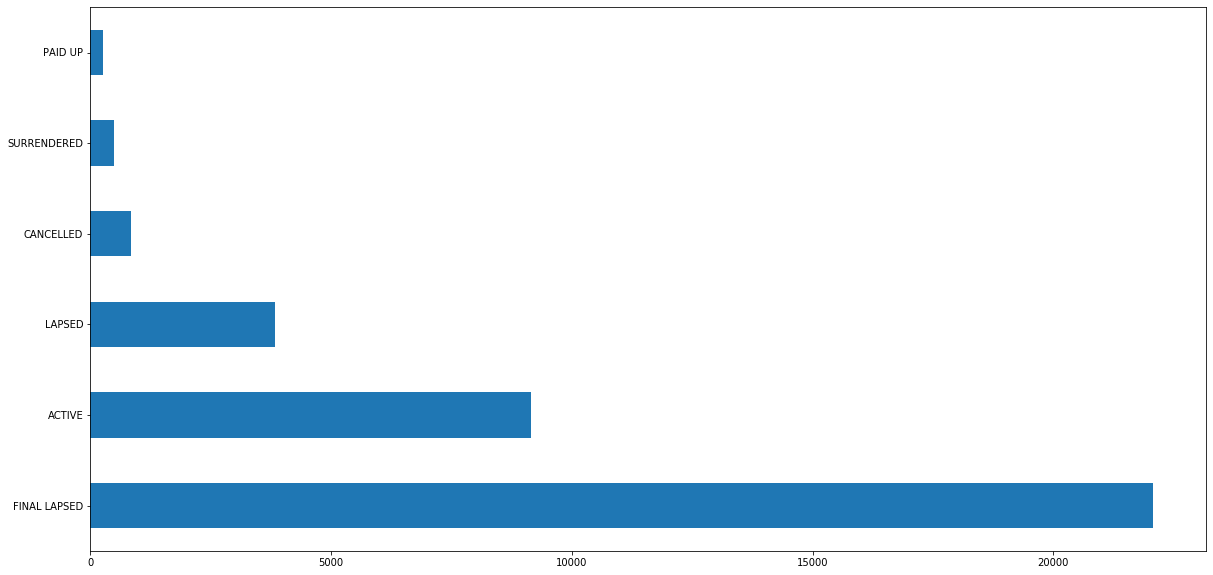

In [9]:
policy = data['STATUS'].value_counts().head(30).plot(kind='barh', figsize=(20,10))

In [10]:
data['STATUS'].value_counts()

FINAL LAPSED    22069
ACTIVE           9147
LAPSED           3834
CANCELLED         838
SURRENDERED       497
PAID UP           256
Name: STATUS, dtype: int64

**Line chart to show policy distribution by underwriting year**

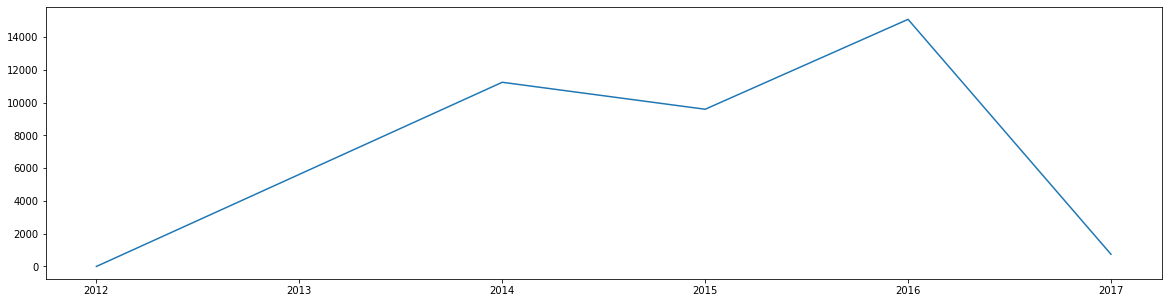

In [11]:
plt.figure(figsize=(20,5))
policy = plt.plot(data['UNDERWRITINGYEAR'].value_counts().sort_index())

In [12]:
data['UNDERWRITINGYEAR'].value_counts()

2016    15072
2014    11234
2015     9589
2017      745
2012        1
Name: UNDERWRITINGYEAR, dtype: int64

**Premium statistical analysis**

In [13]:
data.groupby('UNDERWRITINGYEAR')['PREMIUM'].describe()

,count,mean,std,min,25%,50%,75%,max
UNDERWRITINGYEAR,,,,,,,,
2012,1.0,3000.000000,NaN,3000.0,3000.0,3000.0,3000.0,3000.0
2014,11234.0,3326.955136,5924.065199,525.0,2000.0,2500.0,3000.0,376778.0
2015,9589.0,3224.273180,4233.731831,76.0,2000.0,2500.0,3100.0,166000.0
2016,15072.0,3303.272692,6019.576268,634.0,2000.0,2847.5,3125.0,391064.0
2017,745.0,3743.249060,4838.287650,1000.0,2000.0,3000.0,4000.0,93640.0


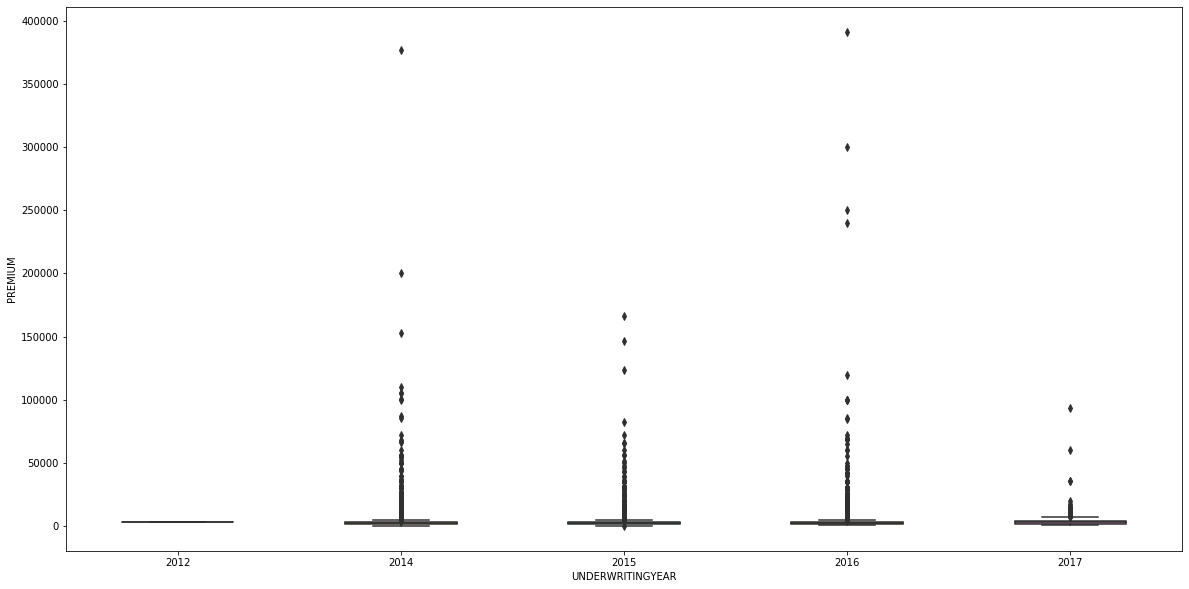

In [14]:
plt.figure(figsize=(20,10))
bplot = sns.boxplot(y='PREMIUM', x='UNDERWRITINGYEAR', 
                 data=data, 
                 width=0.5,
                 palette="colorblind")


**Term statistical analysis**

In [15]:
data.groupby('UNDERWRITINGYEAR')['TERM'].describe()

,count,mean,std,min,25%,50%,75%,max
UNDERWRITINGYEAR,,,,,,,,
2012,1.0,10.000000,NaN,10.0,10.0,10.0,10.0,10.0
2014,11234.0,11.659694,2.555326,5.0,10.0,11.0,13.0,25.0
2015,9589.0,11.756596,2.685541,8.0,10.0,12.0,13.0,25.0
2016,15072.0,11.727508,2.598518,8.0,10.0,12.0,13.0,60.0
2017,745.0,11.315436,2.814821,5.0,10.0,10.0,13.0,18.0


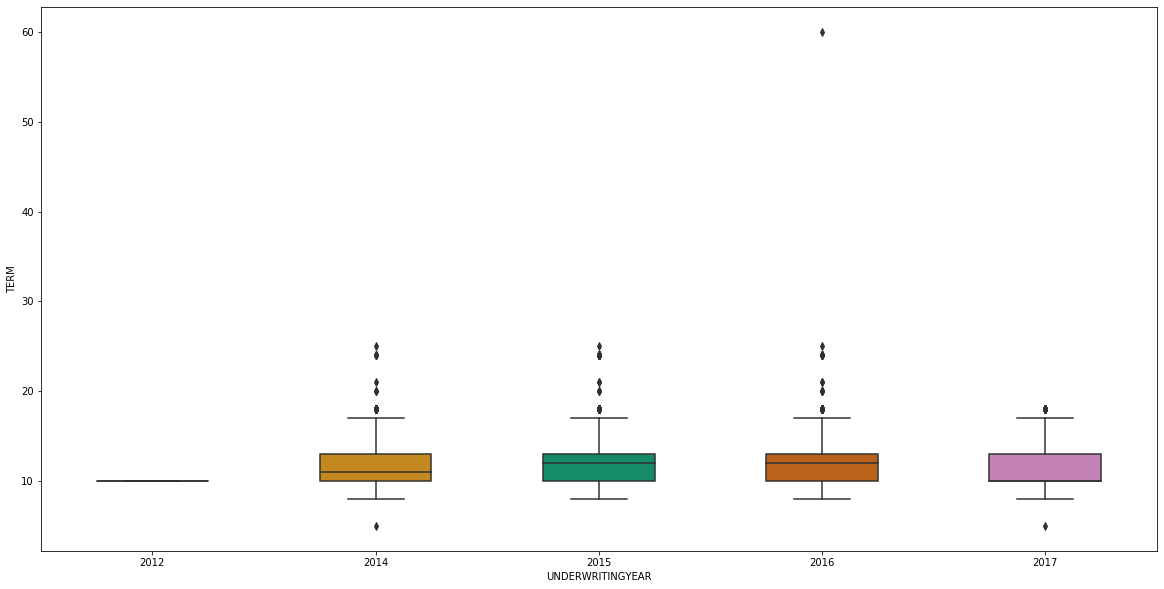

In [16]:
plt.figure(figsize=(20,10))
bplot = sns.boxplot(y='TERM', x='UNDERWRITINGYEAR', 
                 data=data, 
                 width=0.5,
                 palette="colorblind")

**Age statistical analysis**

In [17]:
data.groupby('UNDERWRITINGYEAR')['ANB'].describe()

,count,mean,std,min,25%,50%,75%,max
UNDERWRITINGYEAR,,,,,,,,
2012,1.0,38.000000,NaN,38.0,38.0,38.0,38.0,38.0
2014,11234.0,35.634324,8.365152,3.0,29.0,34.0,41.0,68.0
2015,9589.0,35.881218,8.397916,19.0,29.0,34.0,41.0,69.0
2016,15072.0,34.855096,8.307672,19.0,29.0,33.0,40.0,70.0
2017,745.0,34.759732,8.213874,20.0,29.0,33.0,39.0,68.0


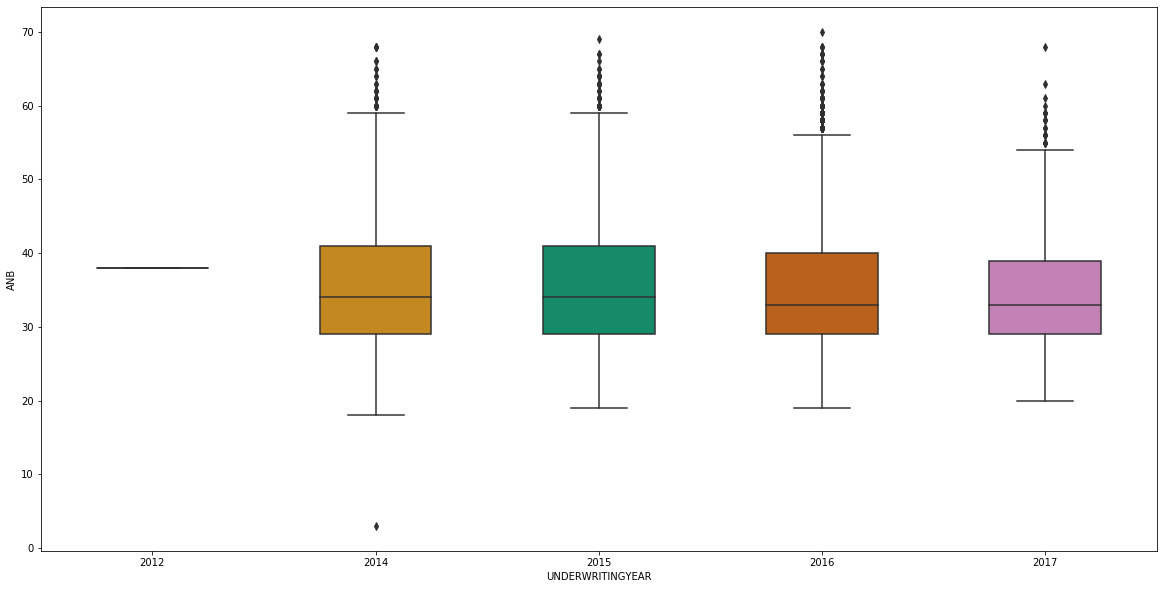

In [18]:
plt.figure(figsize=(20,10))
bplot = sns.boxplot(y='ANB', x='UNDERWRITINGYEAR', 
                 data=data, 
                 width=0.5,
                 palette="colorblind")

**Sum assured statistical analysis**

In [19]:
data.groupby('UNDERWRITINGYEAR')['SUMASSURED'].describe()

,count,mean,std,min,25%,50%,75%,max
UNDERWRITINGYEAR,,,,,,,,
2012,1.0,128603.000000,NaN,128603.0,128603.00,128603.0,128603.00,128603.0
2014,11234.0,187368.045715,244128.874055,0.0,96960.00,141004.0,211366.00,10599875.0
2015,9589.0,188581.439909,643869.494533,0.0,96015.00,141777.0,216448.00,61000000.0
2016,15072.0,188308.012644,300156.347657,7330.0,102918.25,146970.5,217802.75,30000000.0
2017,745.0,184623.270295,128066.164277,30602.0,102893.00,147767.0,214592.00,1044815.0


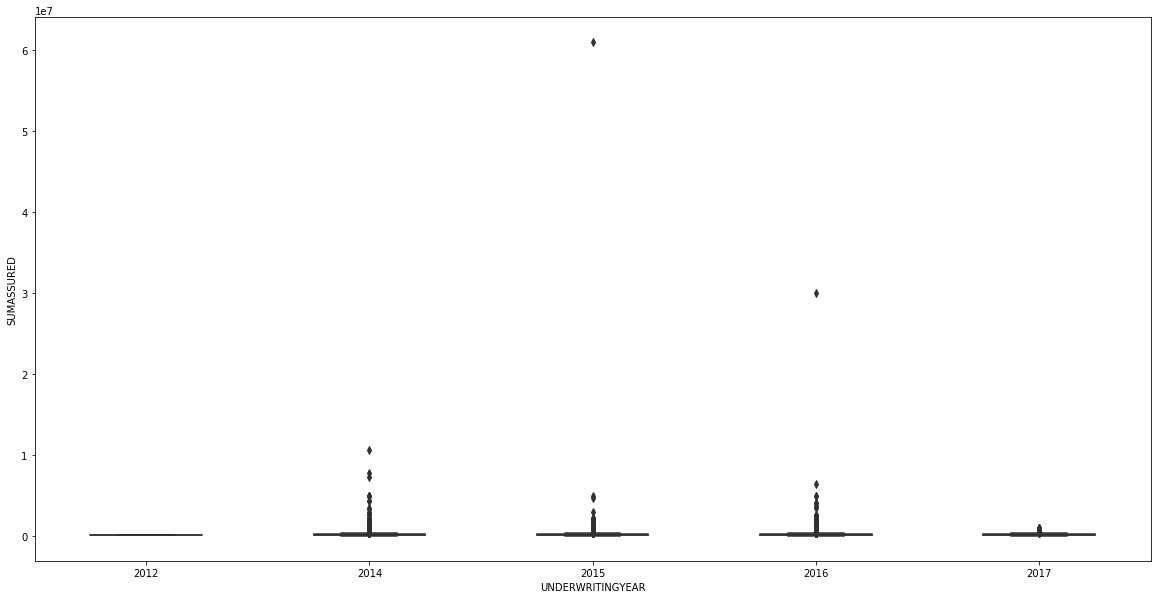

In [20]:
plt.figure(figsize=(20,10))
bplot = sns.boxplot(y='SUMASSURED', x='UNDERWRITINGYEAR', 
                 data=data, 
                 width=0.5,
                 palette="colorblind")

**Data analysis using pandas-profiling, shows data correction, statistical analysis (Mode, Median, Mean, std, var)**

In [21]:
profile = ProfileReport(data)
profile

C:\ProgramData\Anaconda3\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,16
Number of observations,36641
Total Missing (%),0.0%
Total size in memory,4.5 MiB
Average record size in memory,128.0 B
Numeric,6
Categorical,7
Boolean,0
Date,2
Text (Unique),1
Rejected,0


**Function to create the submission CSV file**

In [21]:
def create_csv_submission_file(model, X_test):
    y_test_pred = model.predict(X_test)
    predictions = pd.Series(data=y_test_pred, 
                            index=X_test.index, 
                            name='PREDICTED_STATUS')
    
    date = pd.Timestamp.now().strftime(format='%Y-%m-%d_%H-%M_')
    predictions.to_csv(f'../predictions/{date}predicted_policy_status.csv', 
                       index=True, header=True)

In [22]:
data.isna()

,PRODUCT,OCCUPATION,GENDER,EFFECTIVEDATE,UNDERWRITINGYEAR,TERM,ANB,FREQOFPAYMENT,PAYMETHOD,SUMASSURED,PAIDTODATE,PREMIUM,OSPREM,INCEPTIONDATE,STATUS
POLICYNO,,,,,,,,,,,,,,,
8868646,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8868518,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
MMM/06645/2016,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
MMM/06258/2015,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
MMM/00119/2015,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BYK8858774,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
BYK/25669/2015,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
BYK8866002,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [23]:
data.shape

(36641, 15)

In [24]:
data.head()

,PRODUCT,OCCUPATION,GENDER,EFFECTIVEDATE,UNDERWRITINGYEAR,TERM,ANB,FREQOFPAYMENT,PAYMETHOD,SUMASSURED,PAIDTODATE,PREMIUM,OSPREM,INCEPTIONDATE,STATUS
POLICYNO,,,,,,,,,,,,,,,
8868646,BIMA YA KARO,TEACHER [CLASS 1],M,2015-01-09,2015,15,43,M,K,214592.00,2020-03-31,3000.0,2169.0,1/9/2015,ACTIVE
8868518,BIMA YA KARO,SALES REPRESENTATIVE [CLASS 3],M,2015-01-04,2015,10,42,M,K,139388.00,2015-07-31,3300.0,188100.0,12/11/2014,FINAL LAPSED
MMM/06645/2016,MADISON MONEY MAX,DEAN OF STUDENTS [CLASS 1],M,2016-01-01,2016,8,68,M,S,816721.66,2016-01-31,21000.0,1071000.0,1/1/2016,FINAL LAPSED
MMM/06258/2015,MADISON MONEY MAX,DOCTOR [CLASS 1],M,2015-01-12,2015,8,67,M,S,1000000.00,2015-12-01,35886.0,1901958.0,1/12/2015,FINAL LAPSED
MMM/00119/2015,MADISON MONEY MAX,DEAN OF STUDENTS [CLASS 1],M,2015-01-01,2015,8,67,M,S,500000.00,2016-01-31,82747.0,4213329.0,1/1/2015,FINAL LAPSED


In [25]:
# creating bool series True for NaN values  
bool_series = pd.isnull(data['ANB'])  
    
# filtering data  
# displaying data only with Gender = NaN  
data[bool_series]  

,PRODUCT,OCCUPATION,GENDER,EFFECTIVEDATE,UNDERWRITINGYEAR,TERM,ANB,FREQOFPAYMENT,PAYMETHOD,SUMASSURED,PAIDTODATE,PREMIUM,OSPREM,INCEPTIONDATE,STATUS
POLICYNO,,,,,,,,,,,,,,,


In [26]:
bool_series.shape

(36641,)

In [27]:
#data.dropna(axis = 0, inplace = True)

In [28]:
data.shape

(36641, 15)

**Model with Categorical and Numerical Features**

In [29]:
y = data['STATUS']
y.head()

POLICYNO
8868646                 ACTIVE
8868518           FINAL LAPSED
MMM/06645/2016    FINAL LAPSED
MMM/06258/2015    FINAL LAPSED
MMM/00119/2015    FINAL LAPSED
Name: STATUS, dtype: object

In [30]:
X = data.loc[:, :'INCEPTIONDATE']
X

,PRODUCT,OCCUPATION,GENDER,EFFECTIVEDATE,UNDERWRITINGYEAR,TERM,ANB,FREQOFPAYMENT,PAYMETHOD,SUMASSURED,PAIDTODATE,PREMIUM,OSPREM,INCEPTIONDATE
POLICYNO,,,,,,,,,,,,,,
8868646,BIMA YA KARO,TEACHER [CLASS 1],M,2015-01-09,2015,15,43,M,K,214592.00,2020-03-31,3000.0,2169.0,1/9/2015
8868518,BIMA YA KARO,SALES REPRESENTATIVE [CLASS 3],M,2015-01-04,2015,10,42,M,K,139388.00,2015-07-31,3300.0,188100.0,12/11/2014
MMM/06645/2016,MADISON MONEY MAX,DEAN OF STUDENTS [CLASS 1],M,2016-01-01,2016,8,68,M,S,816721.66,2016-01-31,21000.0,1071000.0,1/1/2016
MMM/06258/2015,MADISON MONEY MAX,DOCTOR [CLASS 1],M,2015-01-12,2015,8,67,M,S,1000000.00,2015-12-01,35886.0,1901958.0,1/12/2015
MMM/00119/2015,MADISON MONEY MAX,DEAN OF STUDENTS [CLASS 1],M,2015-01-01,2015,8,67,M,S,500000.00,2016-01-31,82747.0,4213329.0,1/1/2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BYK8858774,BIMA YA KARO,MECHANIC [CLASS 2],M,2014-01-10,2014,14,27,M,R,148920.00,2015-05-31,2000.0,116500.0,4/9/2014
BYK/25669/2015,BIMA YA KARO,NURSE [CLASS 1],M,2015-01-10,2015,10,37,M,C,223015.00,2015-10-31,5000.0,267228.0,31/07/2015
BYK8866002,BIMA YA KARO,TEACHER [CLASS 1],M,2014-01-10,2014,10,37,M,K,85975.00,2020-05-31,2000.0,-2000.0,26/07/2014


In [31]:
numerical_features = X.select_dtypes(include='number').columns.to_list()
numerical_features

['UNDERWRITINGYEAR', 'TERM', 'ANB', 'SUMASSURED', 'PREMIUM', 'OSPREM']

In [32]:
categorical_features = X.select_dtypes(include='object').columns.to_list()
categorical_features

['PRODUCT',
 'OCCUPATION',
 'GENDER',
 'FREQOFPAYMENT',
 'PAYMETHOD',
 'INCEPTIONDATE']

In [33]:
date_features = data.select_dtypes(include='datetime64[ns]').columns.to_list()
date_features

['EFFECTIVEDATE', 'PAIDTODATE']

**Model using Extreme Gradient Boosting Classifier**

In [34]:
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

ct = ColumnTransformer(remainder="drop",
                       transformers=[
                           ('numerical', numerical_pipe, numerical_features),
                           ('categorical', categorical_pipe, categorical_features)
                       ])

model = Pipeline([
    ('ct', ct),
    ('classifier', XGBClassifier(
                 learning_rate =0.1,
                 n_estimators=100,
                 max_depth=40,
                 min_child_weight=1,
                 gamma=0,
                 subsample=0.8,
                 colsample_bytree=0.8,
                 objective= 'binary:logistic',
                 nthread=4,
                 scale_pos_weight=1,
                 seed=27))
])

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ct',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                                   

In [37]:
print(model.score(X_train, y_train))

0.9996247270742358


In [38]:
print(model.score(X_test, y_test))

0.9275480966025379


In [39]:
model.named_steps

{'ct': ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                   transformer_weights=None,
                   transformers=[('numerical',
                                  Pipeline(memory=None,
                                           steps=[('imputer',
                                                   SimpleImputer(add_indicator=False,
                                                                 copy=True,
                                                                 fill_value=None,
                                                                 missing_values=nan,
                                                                 strategy='mean',
                                                                 verbose=0)),
                                                  ('scaler',
                                                   StandardScaler(copy=True,
                                                                  with_mean=True,
   

**Model using Support Vector Machine Classifier**

In [40]:
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

ct = ColumnTransformer(remainder="drop",
                       transformers=[
                           ('numerical', numerical_pipe, numerical_features),
                           ('categorical', categorical_pipe, categorical_features)
                       ])

modelsvc = Pipeline([
    ('ct', ct),
    ('classifier', SVC(kernel='linear',verbose = -1))
])

In [41]:
modelsvc.fit(X_train, y_train)

[LibSVM]

Pipeline(memory=None,
         steps=[('ct',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                                   

In [42]:
print(modelsvc.score(X_train, y_train))

0.89444596069869


In [43]:
print(modelsvc.score(X_test, y_test))

0.8642379587938327


In [44]:
create_csv_submission_file(model, X_test)

**Create a pickle file to be used later**

In [45]:
import gzip
import dill

with gzip.open("../pickle/policy_persistency.dll.gz","wb") as f:
    dill.dump(model, f, recurse=True)

**Predict policy status for the active policies**

In [46]:
data_to_predict = import_csv_data('../data/persistency/active_policies.csv')

data_to_predict.head()

,PRODUCT,OCCUPATION,GENDER,EFFECTIVEDATE,UNDERWRITINGYEAR,TERM,ANB,FREQOFPAYMENT,PAYMETHOD,SUMASSURED,PAIDTODATE,PREMIUM,OSPREM,INCEPTIONDATE
POLICYNO,,,,,,,,,,,,,,
BMC4706113,BIMA CHALI,LABORATORY TECHNOLOGIST [CLASS 2],M,2011-01-06,2011,8,35.0,M,R,74213.0,2011-10-31,3000.0,273000.0,27/04/2011
LS3254211,MADISON SCHOOL FEES POLICY,TEACHER [CLASS 1],F,2001-01-02,2001,18,35.0,M,K,71700.0,2019-01-31,840.0,0.0,1/2/2001
LR3254850,WHOLE LIFE POLICY,CIVIL SERVANT [CLASS 1],M,2001-01-06,2001,10,47.0,M,K,68700.0,2011-07-31,652.0,0.0,1/6/2001
LD3252812,MORTGAGE PROTECTION,ADMINISTRATOR [CLASS 1],F,2001-01-03,2001,10,47.0,A,C,1300000.0,2018-02-28,7644.0,0.0,1/3/2001
LD3254639,WHOLE LIFE POLICY,CUSTOMS OFFICER [CLASS 1],M,2001-01-05,2001,10,33.0,M,K,120300.0,2011-06-30,800.0,0.0,1/5/2001


In [47]:
#data_to_predict['MEDICAL'] = data_to_predict['MEDICAL'].fillna('N')

In [48]:
#data_to_predict.shape

In [49]:
#data_to_predict.dropna(axis = 0, inplace = True)

In [50]:
#data_to_predict.shape

**Create an csv file with policy status prediction**

In [51]:
create_csv_submission_file(model, data_to_predict)

In [52]:
type(model.steps[1])

tuple

In [53]:
model.named_steps.classifier

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=40,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=4, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.8, verbosity=1)

**Using Extreme Gradient Boost classifier, plot_tree function to plot the decision tree**

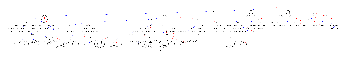

In [54]:
plot_tree(model.named_steps.classifier,num_trees=0)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

**Using Extreme Gradient Boost classifier, plot_importance function to find the feature importance**

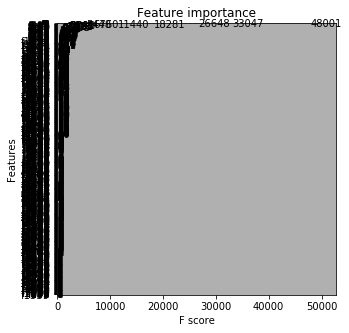

In [55]:
plot_importance(model.named_steps.classifier)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

In [56]:
#print(model.named_steps.classifier.feature_importances_.)

In [57]:
print(model.named_steps.classifier.feature_importances_[:11])

[0.00195448 0.00080872 0.00056802 0.0008027  0.00191402 0.01033217
 0.00087327 0.00112776 0.00210293 0.00362286 0.        ]


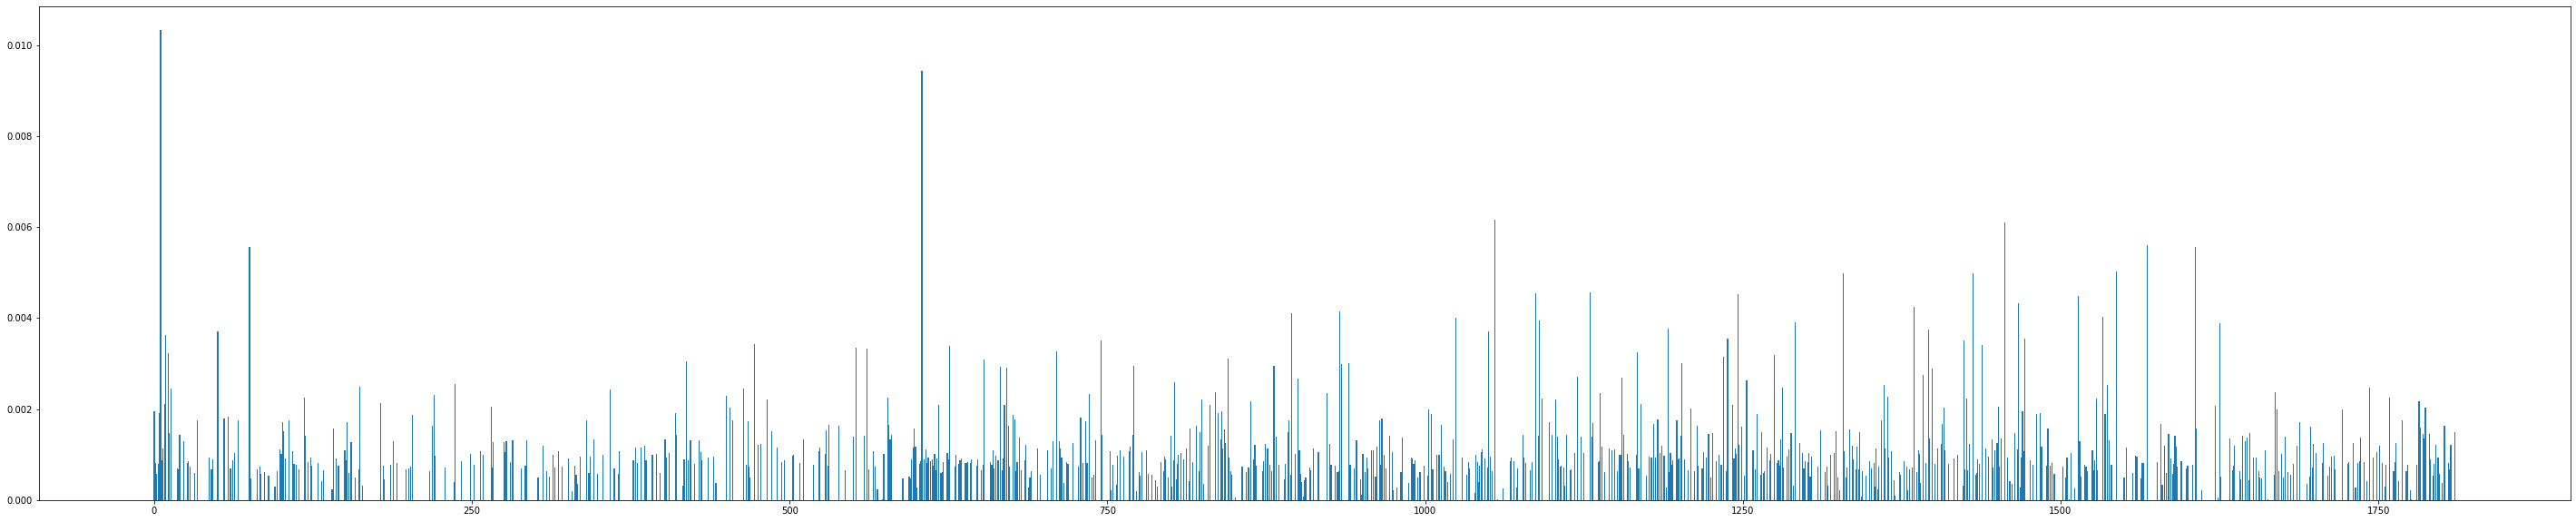

In [58]:

plt.bar(range(len(model.named_steps.classifier.feature_importances_)), model.named_steps.classifier.feature_importances_)
plt.show()

**Getting feature importance using ELI5**
**Most important been: Outstanding Premium, Client Age, Policy frequency of Payment, Policy Term and  Gender**

**Using eli5 library to find out the features weight**

In [59]:
features = eli5.explain_weights_df(model.named_steps.classifier)

In [60]:
features

,feature,weight
0,f5,0.010332
1,f604,0.009440
2,f1055,0.006170
3,f1456,0.006104
4,f1568,0.005606
...,...,...
1806,f924,0.000000
1807,f1723,0.000000
1808,f922,0.000000
1809,f921,0.000000


**Create csv file to log each feature and its weight**

In [61]:
features.to_csv(r'../data/persistency/feature_importance.csv', index = False)

In [62]:
#eli5.explain_prediction_xgboost(model.named_steps.classifier)

In [63]:
eli5.explain_weights_xgboost(model.named_steps.classifier)

Weight,Feature
0.0103,f5
0.0094,f604
0.0062,f1055
0.0061,f1456
0.0056,f1568
0.0056,f75
0.0056,f1606
0.0050,f1544
0.0050,f1329
0.0050,f1431


In [64]:
booster = model.named_steps.classifier.get_booster()

In [65]:
original_feature_names = booster.feature_names
print(booster.get_dump()[0])

0:[f5<-0.493269831] yes=1,no=2,missing=1
	1:[f5<-0.514881134] yes=3,no=4,missing=3
		3:[f5<-0.550571799] yes=7,no=8,missing=7
			7:[f5<-0.722776949] yes=15,no=16,missing=15
				15:[f377<-9.53674316e-007] yes=31,no=32,missing=31
					31:[f4<-0.195098907] yes=57,no=58,missing=57
						57:[f1<-1.03420365] yes=87,no=88,missing=87
							87:leaf=-0.0315789469
							88:[f1<-0.462136984] yes=115,no=116,missing=115
								115:leaf=0.11249999
								116:leaf=0.0157894716
						58:[f1<1.06337428] yes=89,no=90,missing=89
							89:[f5<-1.26876664] yes=117,no=118,missing=117
								117:leaf=0.0488372073
								118:leaf=0.243037969
							90:leaf=0.0488372073
					32:leaf=-0.00566037884
				16:[f602<-9.53674316e-007] yes=33,no=34,missing=33
					33:[f83<-9.53674316e-007] yes=59,no=60,missing=59
						59:[f188<-9.53674316e-007] yes=91,no=92,missing=91
							91:leaf=0.292946428
							92:leaf=0.0906976685
						60:leaf=0.0631578937
					34:[f9<-9.53674316e-007] yes=61,no=62,missing=61
						61:

**Top 5 weighted model features using eli5**

In [66]:
eli5.show_weights(model.named_steps.classifier, top=5)
